In [38]:
import networkx as nx

G = nx.read_graphml("THE_GRAPH.graphml")
print(G)

Graph with 1031 nodes and 1279 edges


In [39]:
#visualize the graph with folium
import folium
import os

def plot_graph_folium(G, output_file="graph_map.html", cablesDir = None):
    # Extract coordinates from node attributes
    coords = [(d["lon"], d["lat"]) for _, d in G.nodes(data=True)]
    lons, lats = zip(*coords)
    
    # Center map on average position
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=3, tiles="CartoDB positron")

    # Add nodes
    for n, d in G.nodes(data=True):
        lon, lat = d["lon"], d["lat"]
        desc = d.get("description", "")
        location = f"lon: {lon} lat: {lat}"
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=f"Node {n}<br>{desc}<br>{location}",
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.7
        ).add_to(m)

    # Add edges
    for u, v in G.edges():
        lon1, lat1 = G.nodes[u]["lon"], G.nodes[u]["lat"]
        lon2, lat2 = G.nodes[v]["lon"], G.nodes[v]["lat"]
        folium.PolyLine(
            locations=[(lat1, lon1), (lat2, lon2)],
            color="red",
            weight=2,
            opacity=0.6
        ).add_to(m)
    
    #overlay the "real network"
    if cablesDir is not None:
        # Loop through all files in the directory
        for filename in os.listdir(cablesDir):
            if filename.endswith(".geojson"):
                filepath = os.path.join(cablesDir, filename)
                folium.GeoJson(filepath).add_to(m)

    # Save map as HTML
    m.save(output_file)
    print(f"Map saved to {output_file}")
    
plot_graph_folium(G, output_file="graph_map_overlayed_fixed.html", cablesDir="cablesGeojson/")
plot_graph_folium(G, output_file="graph_map_fixed.html")

Map saved to graph_map_overlayed_fixed.html
Map saved to graph_map_fixed.html


c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


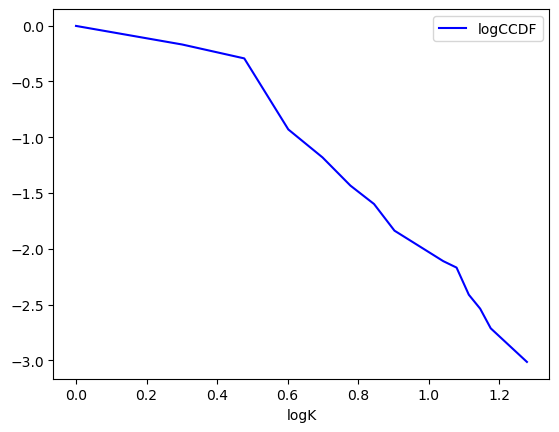

In [40]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_ccdf(G):
   dd = Counter(dict(G.degree).values())##get degree distribution (key is degree, value is count)
   dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")#put them in a dataframe and sort by degree
   ccdf = dd.sort_values(by = "k", ascending = False)#sort in descending order in new dataframe
   ccdf["cumsum"] = ccdf["count"].cumsum()#make cumulative sum column
   ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()#divide by sum of counts to get density
   ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")#sort again by the degree (ascending)
   return ccdf

def makeLogLog(df_CCDF):
    df_CCDF["logK"] = np.log10(df_CCDF["k"])
    df_CCDF["logCCDF"] = np.log10(df_CCDF["ccdf"])
    return df_CCDF

# Compute the CCDF using this function.
CCDF = generate_ccdf(G)
#make log log scale:
CCDF = makeLogLog(CCDF)

# Print the resulting dataframes to see the structure is the same as last week
CCDF.plot(x="logK", y="logCCDF", c="blue")#real graph is blue
plt.show()

In [41]:
import powerlaw as pl

def generate_dd(G):
    dd = [x for x in dict(G.degree).values()]
    return dd
    
def checkPowerLawLogNormal(degreeDistribution):
    results = pl.Fit(degreeDistribution)
    print("Alpha:", results.power_law.alpha)#print the estimated power law exponent
    print(f"p(x) = x^(-{results.power_law.alpha})")
    print("k-min:", results.power_law.xmin)#print the estimated cutoff for the shifted powerlaw (kmin)
    R, p = results.distribution_compare("power_law", "lognormal")#compare power law against lognormal
    #positive R: power law more likely, negative R: lognormal more likely -> we trust becaues p=0.043
    print(f"Testing power_law vs. lognormal returned R={R} with p={p}")
    
#estimate power law exponent with package:
checkPowerLawLogNormal(generate_dd(G))

Calculating best minimal value for power law fit
Alpha: 8.634676221390281
p(x) = x^(-8.634676221390281)
k-min: 12.0
Testing power_law vs. lognormal returned R=-0.642355396359757 with p=0.2586056738339829


Values less than or equal to 0 in data. Throwing out 0 or negative values
c:\ProgramData\anaconda3\Lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


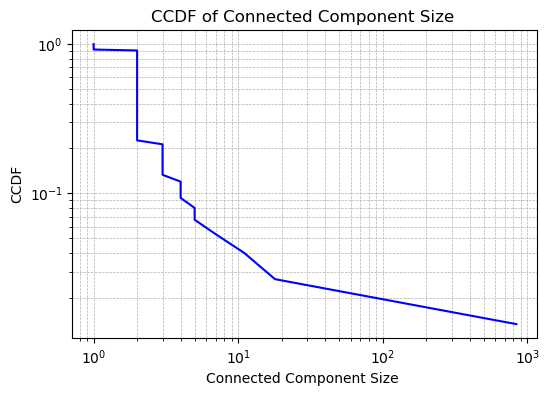

Sizes of the 10 largest connected components:
[841, 18, 11, 7, 5, 5, 4, 4, 4, 3]


In [42]:
#get size of the connected components:

sizesCC = [len(CC) for CC in nx.connected_components(G)]

def plotCCDF(data, dataName):
    """
    Plots the CCDF (Complementary Cumulative Distribution Function) of a 1D data array.

    Parameters:
    - data: array-like, 1D distribution data
    - xlabel: str, label for x-axis
    - ylabel: str, label for y-axis
    - title: str, plot title
    - show: bool, whether to call plt.show() immediately
    """
    data = np.array(data)
    
    # Sort data in ascending order
    sorted_data = np.sort(data)
    
    # Calculate CCDF values
    # Empirical CCDF: for each value, fraction of points >= that value
    ccdf = 1.0 - np.arange(0, len(sorted_data)) / len(sorted_data)
    
    plt.figure(figsize=(6,4))
    plt.loglog(sorted_data, ccdf, linestyle='-', color='blue')
    plt.xlabel(dataName)
    plt.ylabel("CCDF")
    plt.title(f"CCDF of {dataName}")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

plotCCDF(sizesCC, "Connected Component Size ")
print("Sizes of the 10 largest connected components:")
print(sorted(sizesCC, reverse=True)[:10])